In [1]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import brier_score_loss
from sklearn.metrics import classification_report


In [2]:
svm_model = joblib.load('SVM_model.pkl')

train_features = pd.read_csv('./DATASET/train_features.csv')
train_labels = pd.read_csv('./DATASET/train_labels.csv').values.ravel()

test_features = pd.read_csv('./DATASET/test_features.csv')
test_labels = pd.read_csv('./DATASET/test_labels.csv').values.ravel()

val_features = pd.read_csv('./DATASET/val_features.csv')
val_labels = pd.read_csv('./DATASET/val_labels.csv').values.ravel()

In [3]:
print("Model Parameters:", svm_model.get_params())
parameters = svm_model.get_params()

Model Parameters: {'C': 10, 'break_ties': False, 'cache_size': 200, 'class_weight': 'balanced', 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [4]:
svm_model = SVC(probability=True, C=parameters['C'], kernel=parameters['kernel'], gamma=parameters['gamma'], class_weight=parameters['class_weight'], degree=parameters['degree'])
svm_model.fit(train_features, train_labels)

SVC(C=10, class_weight='balanced', probability=True)

In [5]:
def evaluate_model(model, features, labels):
    predictions = model.predict(features)
    probabilities = model.predict_proba(features)[:, 1]

    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions)
    recall = recall_score(labels, predictions)
    f1 = f1_score(labels, predictions)

    fpr, tpr, _ = roc_curve(labels, probabilities)
    roc_auc = auc(fpr, tpr)


    return accuracy, precision, recall, f1, fpr, tpr, roc_auc

svm_metrics = evaluate_model(svm_model, test_features, test_labels)

accuracy, precision, recall, f1, fpr, tpr, roc_auc = svm_metrics
print("SVM - Accuracy: {:.2f}, Precision {:.2f}, Recall {:.2f}, F1 Score {:.2f}, AUC {:.2f}".format(accuracy, precision, recall, f1, roc_auc))

SVM - Accuracy: 0.82, Precision 0.98, Recall 0.70, F1 Score 0.82, AUC 0.93


In [6]:
y_svm = svm_model.predict(train_features)
y_predict_svm = svm_model.predict(test_features)

print("Accuracy (Train):", metrics.accuracy_score(train_labels, y_svm))
print("Accuracy (Test):", metrics.accuracy_score(test_labels, y_predict_svm))

Accuracy (Train): 0.9964377145805632
Accuracy (Test): 0.8203513129879347


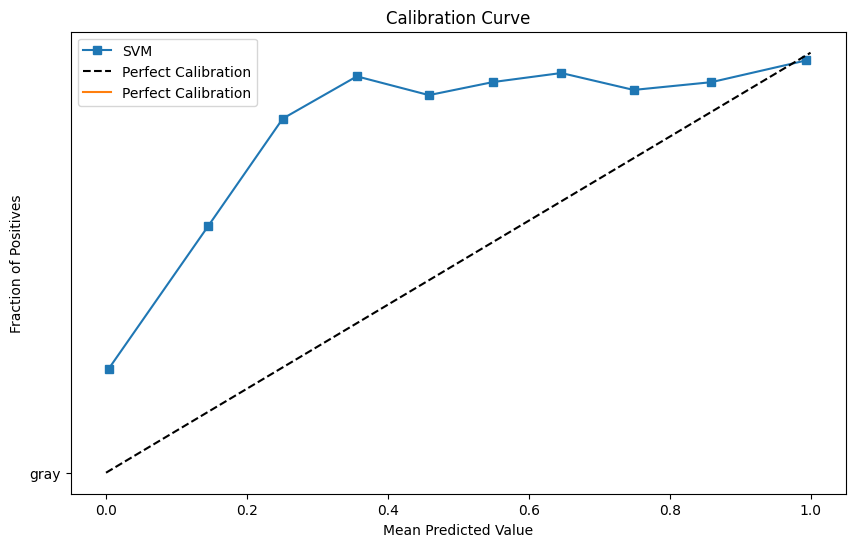

In [7]:
svm_probs = svm_model.predict_proba(test_features)[:, 1] if hasattr(svm_model, 'predict_proba') else None

if svm_probs is not None:
    fraction_of_positives, mean_predicted_value = calibration_curve(test_labels, svm_probs, n_bins=10)

plt.figure(figsize=(10, 6))
if svm_probs is not None:
    plt.plot(mean_predicted_value, fraction_of_positives, 's-', label='SVM')

plt.plot([0, 1], [0, 1], 'k--', 'gray', label='Perfect Calibration')
plt.xlabel('Mean Predicted Value')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()

In [8]:
model_to_clf = {
    'SVM': svm_model
}

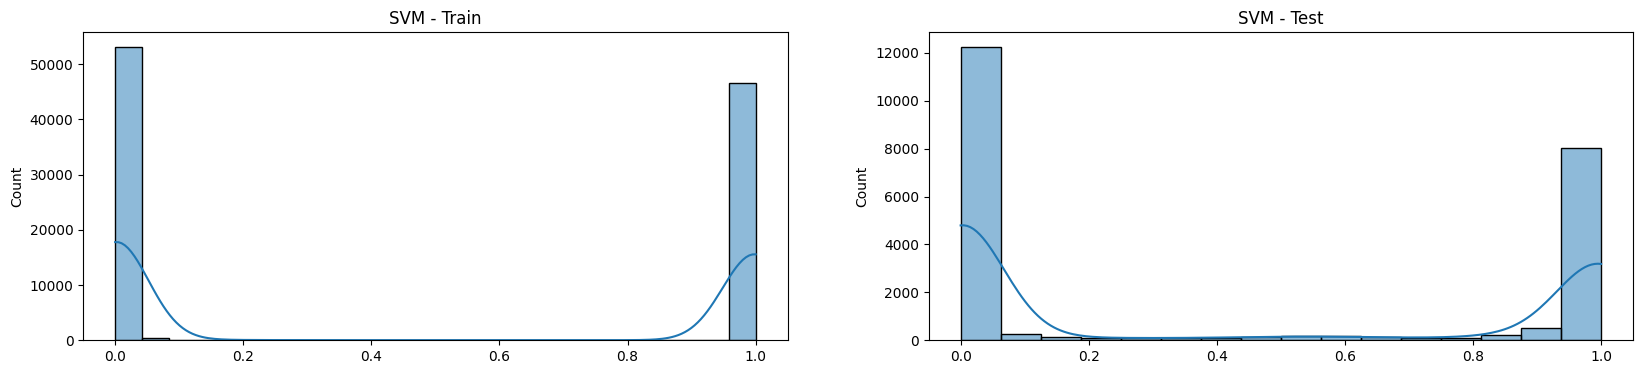

In [9]:
model_to_probs = {}
model_str_to_trained_model = {}

for model_str, model in model_to_clf.items():
    model.fit(train_features, train_labels)
 
    pred_probs_train = model.predict_proba(train_features)[:, 1]
    pred_probs_test = model.predict_proba(test_features)[:, 1]
    pred_probs_val = model.predict_proba(val_features)[:, 1]
 
    model_to_probs[model_str] = {'train': pred_probs_train, 'test': pred_probs_test, 'val': pred_probs_val}
 
    plt.figure(figsize=(20, 4))
    
    plt.subplot(1, 2, 1)
    sns.histplot(pred_probs_train, kde=True)
    plt.title(f'{model_str} - Train')

    plt.subplot(1, 2, 2)
    sns.histplot(pred_probs_test, kde=True)
    plt.title(f'{model_str} - Test')

    model_str_to_trained_model[model_str] = model

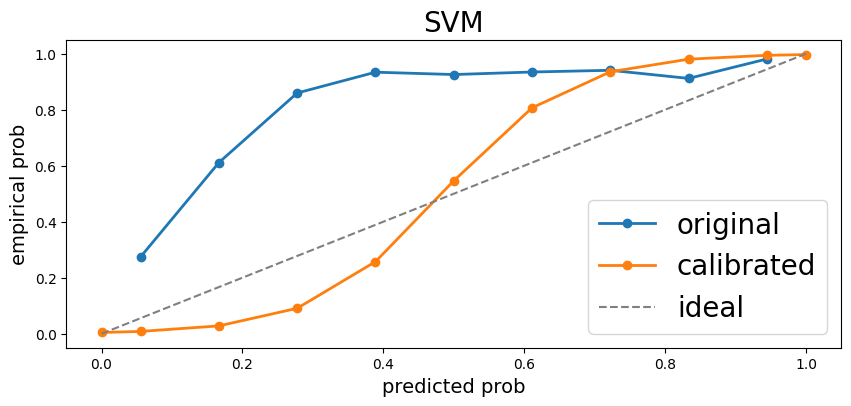

In [10]:
model_str_to_calibrator = {}

for model_str, pred_prob_dict in model_to_probs.items():
    #train calibration model
    ad_model = LogisticRegression()
    ad_model.fit(pred_prob_dict['val'].reshape(-1,1), val_labels)
    
    pred_probs = pred_prob_dict['test']

    pred_probs_space = np.linspace(pred_probs.min(), pred_probs.max(), 10)

    empirical_probs = []
    pred_probs_midpoints = []

    for i in range(len(pred_probs_space)-1):
        mask = (pred_probs > pred_probs_space[i]) & (pred_probs < pred_probs_space[i+1])
        if np.any(mask):
            empirical_probs.append(np.mean(test_labels[mask]))
            pred_probs_midpoints.append((pred_probs_space[i] + pred_probs_space[i+1])/2)

    calibrated_probs = ad_model.predict_proba(np.array([0.0]+pred_probs_midpoints+[1.0]).reshape(-1,1))[:,1]
    
    plt.figure(figsize=(10,4))
    plt.plot(pred_probs_midpoints, empirical_probs, linewidth=2, marker='o')
    plt.title(f"{model_str}", fontsize=20)
    plt.xlabel('predicted prob', fontsize=14)
    plt.ylabel('empirical prob', fontsize=14)
    
    plt.plot([0.0]+pred_probs_midpoints+[1.0], calibrated_probs, linewidth=2, marker='o')
    
    plt.plot([0,1],[0,1],linestyle='--',color='gray')
    
    plt.legend(['original', 'calibrated', 'ideal'], fontsize=20)
    
    model_str_to_calibrator[model_str] = ad_model

In [11]:
uncal_prob = svm_model.predict_proba(test_features.iloc[[0]])[:, 1]
print(f"Uncalibrated Probability: {uncal_prob[0]:.4f}")

cal_prob = model_str_to_calibrator['SVM'].predict_proba(uncal_prob.reshape(-1, 1))[:, 1]
print(f"Calibrated Probability: {cal_prob[0]:.4f}")

Uncalibrated Probability: 1.0000
Calibrated Probability: 0.9969


In [12]:
# Calculate Brier score for uncalibrated and calibrated probabilities
uncal_probs = svm_model.predict_proba(test_features)[:, 1]
cal_probs = model_str_to_calibrator['SVM'].predict_proba(uncal_probs.reshape(-1, 1))[:, 1]

brier_uncal = brier_score_loss(test_labels, uncal_probs)
brier_cal = brier_score_loss(test_labels, cal_probs)
print(f"Brier Score (Uncalibrated): {brier_uncal:.4f}")
print(f"Brier Score (Calibrated): {brier_cal:.4f}")


Brier Score (Uncalibrated): 0.1594
Brier Score (Calibrated): 0.1634


In [13]:
grid_predictions = svm_model.predict(test_features)
print(classification_report(test_labels, grid_predictions))

              precision    recall  f1-score   support

           0       0.71      0.98      0.82      9711
           1       0.98      0.70      0.82     12833

    accuracy                           0.82     22544
   macro avg       0.84      0.84      0.82     22544
weighted avg       0.86      0.82      0.82     22544



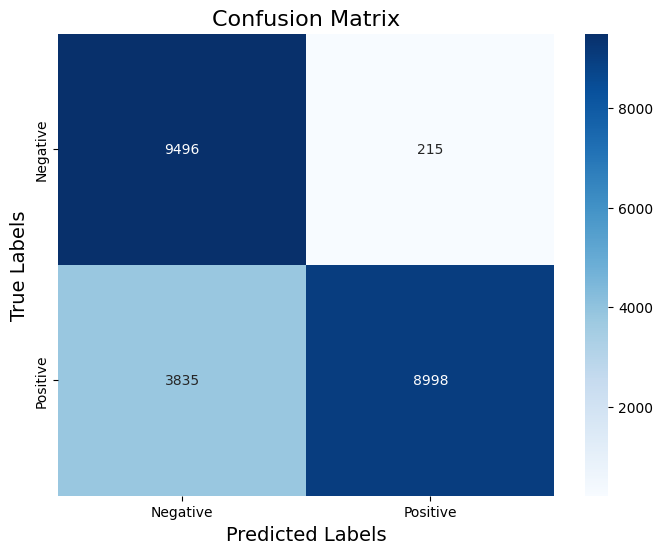

In [14]:

conf_mat = confusion_matrix(test_labels, grid_predictions)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])

plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()


In [15]:
accuracy = (conf_mat[0,0] + conf_mat[1,1])/np.sum(conf_mat)
sensitivity = conf_mat[1,1]/(conf_mat[1,0]+conf_mat[1,1])
specificity = conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
precision = conf_mat[1,1]/(conf_mat[0,1]+conf_mat[1,1])
print('Accuracy    = {}'.format(np.round(accuracy,3)))
print('Sensitvity  = {}'.format(np.round(sensitivity,3)))
print('Specificity = {}'.format(np.round(specificity,3)))
print('Precision   = {}'.format(np.round(precision,3)))

Accuracy    = 0.82
Sensitvity  = 0.701
Specificity = 0.978
Precision   = 0.977


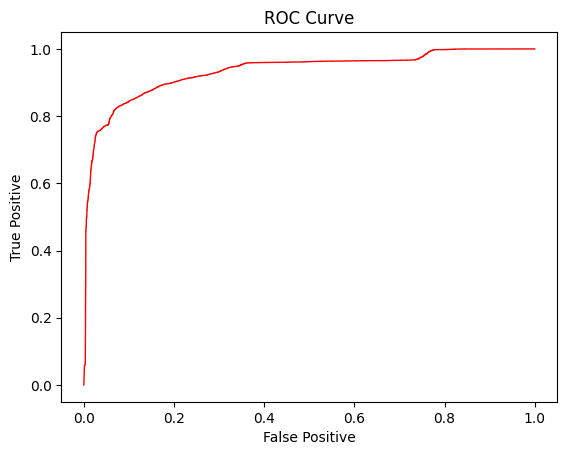

In [16]:
plt.plot(fpr, tpr, c='red', linewidth=1.0)
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC Curve')
plt.show()